# Calculate the probability that 2 household sequences are a transmission pair

This is a notebook taken directly from Alli Black, [here])(https://github.com/blab/ebola-narrative-ms/blob/master/scripts/mutations-and-serial-intervals.ipynb). Alli developed this really lovely little Poisson method for calculating the expected number of mutations per genome per serial interval given a rate of evolution and genome length. I would like to use this to calculate this same thing for SARS-CoV2 as a way to determine the likelihood that that one transmission pair is within a serial interval given that 3 mutations separate them. 

In [1]:
import numpy as np
%matplotlib inline
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd

import re,copy,json,imp

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic.py')

In [2]:
#purple: 5248AA
#blue: 7C9BAC
#yellow: ECC58C
#red: 551E32
#green:434A42

In [3]:
#the math
subs_per_genome_per_year = 21.049   # from nextstrain.org/ncov/global
print("There are {} substitutions that accrue on average across the genome after one year.".format(subs_per_genome_per_year))

subs_per_genome_per_day = subs_per_genome_per_year/365.25
serial_interval = 5.0 # days
subs_per_genome_per_serial_interval = subs_per_genome_per_day * serial_interval
print("On average we expect {} substitutions to accrue over a single serial interval of 5 days.".format(subs_per_genome_per_serial_interval))

#subs_per_genome_per_serial interval is an average of how many substitutions we would expect to accrue over a serial interval
#in reality the observed number of substitutions is discrete, and we see, 0, 1, 2, etc. mutations with different probabilities,
#which is what we plot below: the probability of x subsitutions observed given a SINGLE serial interval.

There are 21.049 substitutions that accrue on average across the genome after one year.
On average we expect 0.28814510609171795 substitutions to accrue over a single serial interval of 5 days.


In [5]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex='false') 
plt.rcParams.update({'font.size': 18})

In [27]:
fontSize = 24
width = 6
height= 4.3

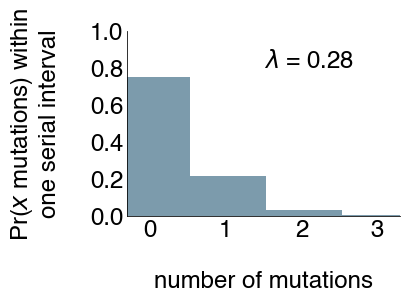

In [28]:
fig,ax = fig, ax = plt.subplots(figsize=(width,height),facecolor='w')

x = np.arange(0,4,1)

rv = poisson(subs_per_genome_per_serial_interval)
ax.vlines(x, 0, rv.pmf(x), colors='#7C9BAC', linestyles='-', lw=80)
ax.set_ylabel("Pr($x$ mutations) within\none serial interval\n", size = fontSize)
ax.set_ylim(0,1)
ax.set_xlim(-0.3,3.3)
ax.set_xlabel("\nnumber of mutations", size = fontSize)
plt.xticks(np.arange(0, 4, step=1))

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    
ax.text(1.5,0.8,'$\lambda$ = 0.28', size = fontSize)
plt.setp(ax.get_xticklabels(), visible=True, size=fontSize)
plt.setp(ax.get_yticklabels(), visible=True, size=fontSize)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()

# ax.vhlines(0.2, -1, 6, colors='white', linestyles='solid', lw=1)
# ax.vlines(0.4, -1, 6, colors='white', linestyles='solid', lw=1)

plt.savefig("../figures/individual-pdfs/serial-interval-mutations-2021-02-04.pdf", dpi=300)

# Way 2 of thinking about this. Plot the deterministic probabilities.

In [7]:
n_serial_intervals = 1
n_mutations_to_assess_probability_of = 3

poisson_distribution = poisson(subs_per_genome_per_serial_interval*n_serial_intervals)

probabilities_of_n_mutations_given_poisson_dist = poisson_distribution.pmf(n_mutations_to_assess_probability_of) #gives probability of x mutations for all of the mutations counts you're wondering about.
print(probabilities_of_n_mutations_given_poisson_dist)
#probability_based_observation_counts = (100*probabilities_of_n_mutations_given_poisson_dist)
#print(probability_based_observation_counts)


0.0029891152728748816


In [8]:
def get_probability_given_n_muts_and_n_serial_intervals(subs_per_genome_per_serial_interval, n_serial_intervals, n_mutations_to_assess_probability_of):
    '''
    this returns a numpy array with an integer count representing out of 100 trials, how many times you'd expect to see x mutations.
    subs_per_genome_per_serial_interval is a float describing the number of substitutions you'd expect to see across the genome after a single serial interval.
    n_serial_intervals is an integer that describes how many serial intervals you're interested in.
    n_mutations_to_assess_probability_of is a list of integers from 0 to however many you choose that represents 0 mutations, 1 mutation etc.
    '''
    poisson_distribution = poisson(subs_per_genome_per_serial_interval*n_serial_intervals)
    return poisson_distribution.pmf(n_mutations_to_assess_probability_of) 


# Given a tree, compute the number of mutations between each household pair

I would like to read in a tree and compute, for each pair, the number of mutations that separate those pairs. I can then write out the probability that each one is a transmission event within 1 serial interval. 

In [5]:
"""This is a small, recursive function to return the TMRCA for 2 tips. Starting with the parental node of tip1,
go recursively backwards in the tree until you find an internal node whose children contains both tip1 and 
tip2. Return that node."""

def return_TMRCA_node(input_node,tip1,tip2):
    
    # for a given internal node, generate a list of all its children, i.e., tips descending from that node
    node = input_node
    children = list(node.children)   # .children will output all of the direct descendants as baltic objects
    leaves = list(node.leaves)       # .leaves will output the names of all tips descending from the node
    
    if tip2 in leaves and tip1 in leaves: 
        node_to_return = node
    else:
        node_to_return = return_TMRCA_node(node.parent,tip1,tip2)
    
    return(node_to_return)

In [6]:
"""given 2 tips and a tree, iterate through the tree. when we reach tip 1, run return_TMRCA_node, to find the 
internal node that is the TMRCA for tips 1 and 2. Extract its date and return the node object and date"""

def return_TMRCA(tip1,tip2,tree):
    for k in tree.Objects: 
        if k.branchType == "leaf" and k.name == tip1:
            tmrca_node = return_TMRCA_node(k.parent,tip1,tip2)
            
    return(tmrca_node)

In [7]:
def return_mutations_on_branch(node):
    mutations = []
    
    if 'branch_attrs' in node.traits:
        if 'mutations' in node.traits['branch_attrs']:
            if 'nuc' in node.traits['branch_attrs']['mutations']:
                mutations = node.traits['branch_attrs']['mutations']['nuc']
    else:
        mutations = []
        
    return(mutations)

In [8]:
"""Given a starting internal node, and a tip you would like to end at, traverse the full path from that node to
tip. Along the way, gather nucleotide mutations that occur along that path. Once you have reached the ending 
tip, return the list of mutations that fell along that path"""

def return_divergence_on_path_to_tip(starting_node, ending_tip):
    
    total_mutations_on_path = []
    children = starting_node.children
    
    for child in children:
        
        """if the child is a leaf: if leaf is the target end tip, collect its mutations and return; 
        if leaf is not the target end tip, move on"""
        """if the child is an internal node: first, test whether that child node contains the target tips in its 
        children. child.leaves will output a list of the names of all tips descending from that node. If not, pass. 
        if the node does contain the target end tip in its leaves, keep traversing down that node recursively"""

        if child.branchType == "leaf":
            if child.name != ending_tip:
                pass
            elif child.name == ending_tip:
                child_mutations = return_mutations_on_branch(child)
                for m in child_mutations:
                    total_mutations_on_path.append(m)
                return(total_mutations_on_path)
         
        elif child.branchType == "node":
            if ending_tip not in child.leaves:
                pass
            else:
                node_mutations = return_mutations_on_branch(child)
                for m in node_mutations:
                    total_mutations_on_path.append(m)
                child_mutations = return_divergence_on_path_to_tip(child, ending_tip)
    
    for m in child_mutations:
        total_mutations_on_path.append(m)
        
    return(total_mutations_on_path)

In [9]:
import itertools

def generate_all_combinations_pairs(list_of_elements):
    all_pairs = []
    for pair in itertools.combinations(list_of_elements, 2):
        all_pairs.append(list(pair))
    return(all_pairs)

In [10]:
def return_divergence_between_tips(list_of_households, tree):
    return_df = pd.DataFrame()
    
    for household in list_of_households:
        all_pairs = generate_all_combinations_pairs(household)
        for a in all_pairs:
            tip1 = a[0]
            tip2 = a[1]
            parental_node = return_TMRCA(tip1,tip2,tree)
            parent_divergence = parental_node.traits['node_attrs']['div']
            tip1_divergence = return_divergence_on_path_to_tip(parental_node, tip1)
            tip2_divergence = return_divergence_on_path_to_tip(parental_node, tip2)

            node_to_tip1 = tip1_divergence
            node_to_tip2 = tip2_divergence
            total_mutations = node_to_tip1 + node_to_tip2
            
            probability = get_probability_given_n_muts_and_n_serial_intervals(subs_per_genome_per_serial_interval, n_serial_intervals, len(total_mutations))
            
            df = pd.DataFrame.from_dict({"tip1":[tip1],"tip2":[tip2],"muts_between_tips":[len(total_mutations)],
                                       "muts":[total_mutations],"probability_1_serial_inteval":[probability]})
            return_df = return_df.append(df)
            
    return(return_df)

In [11]:
household_groups = [["USA/WI-UW-27/2020","USA/WI-UW-85/2020"],
                      ["USA/WI-UW-40/2020","USA/WI-UW-97/2020"],
                      ["USA/WI-UW-41/2020","USA/WI-UW-48/2020"],
                      ["USA/WI-UW-65/2020","USA/WI-UW-32/2020"],
                      ["USA/WI-UW-69/2020","USA/WI-UW-61/2020"],
                      ["USA/WI-UW-70/2020","USA/WI-UW-67/2020"],
                      ["USA/WI-UW-74/2020","USA/WI-UW-29/2020"],
                      #["USA/WI-UW-119/2020","USA/WI-UW-120/2020"],  # 119 is missing a consensus genome
                      ["USA/WI-UW-124/2020","USA/WI-UW-351/2020"],
                      ["USA/WI-UW-158/2020","USA/WI-UW-160/2020"],
                      ["USA/WI-UW-264/2020","USA/WI-UW-356/2020"],
                      ["USA/WI-UW-333/2020","USA/WI-UW-334/2020"],
                      ["USA/WI-UW-476/2020","USA/WI-UW-438/2020","USA/WI-UW-432/2020"],
                      ["USA/WI-UW-544/2020","USA/WI-UW-551/2020","USA/WI-UW-575/2020"],
                      ["USA/WI-UW-546/2020","USA/WI-UW-586/2020","USA/WI-UW-443/2020"],
                      ["USA/WI-UW-577/2020","USA/WI-UW-536/2020"],
                      ["USA/WI-UW-598/2020","USA/WI-UW-602/2020","USA/WI-UW-689/2020"],
                      ["USA/WI-UW-601/2020","USA/WI-UW-780/2020"],
                      ["USA/WI-UW-756/2020","USA/WI-UW-893/2020"],
                      ["USA/WI-UW-784/2020","USA/WI-UW-722/2020","USA/WI-UW-749/2020","USA/WI-UW-694/2020","USA/WI-UW-721/2020","USA/WI-UW-798/2020"],
                      ["USA/WI-UW-747/2020","USA/WI-UW-697/2020"],
                      ["USA/WI-UW-855/2020","USA/WI-UW-897/2020","USA/WI-UW-916/2020","USA/WI-UW-906/2020"],
                      ["USA/WI-UW-874/2020","USA/WI-UW-986/2020","USA/WI-UW-997/2020","USA/WI-UW-991/2020"],
                      ["USA/WI-UW-895/2020","USA/WI-UW-876/2020","USA/WI-UW-931/2020","USA/WI-UW-863/2020"],
                      ["USA/WI-UW-927/2020","USA/WI-UW-861/2020"]]

In [28]:
# test this out first on the Wisconsin-only build json
WI_tree_path = "../data/Wisconsin-SARS-CoV-2-ncov-wisconsin-2021-1-15.json"

with open(WI_tree_path) as json_file:
    WI_tree_json = json.load(json_file)
WI_tree_object=WI_tree_json['tree']
WI_meta=WI_tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
#json_meta={'file':WI_meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

WI_tree=bt.loadJSON(WI_tree_object,json_translation)


Tree height: 0.853113
Tree length: 155.604745
multitype tree
annotations present

Numbers of objects in tree: 5452 (2518 nodes and 2934 leaves)



In [29]:
df = return_divergence_between_tips(household_groups, WI_tree)
df.head()

,tip1,tip2,muts_between_tips,muts,probability_1_serial_inteval
0,USA/WI-UW-27/2020,USA/WI-UW-85/2020,0,[],0.749653
0,USA/WI-UW-40/2020,USA/WI-UW-97/2020,0,[],0.749653
0,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0,[],0.749653
0,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0,[],0.749653
0,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0,[],0.749653


In [30]:
sloth = df[df["muts_between_tips"] > 1]
sloth

,tip1,tip2,muts_between_tips,muts,probability_1_serial_inteval
0,USA/WI-UW-264/2020,USA/WI-UW-356/2020,2,"[G17122T, G26634T]",3.112094e-02
0,USA/WI-UW-476/2020,USA/WI-UW-438/2020,11,"[C1059T, C29733T, C11916T, A12820G, C1471T, A7...",2.135149e-14
0,USA/WI-UW-476/2020,USA/WI-UW-432/2020,11,"[C1059T, C29733T, C11916T, A12820G, C1471T, A7...",2.135149e-14
0,USA/WI-UW-784/2020,USA/WI-UW-722/2020,4,"[C27577T, C6500T, C27577T, C2939T]",2.153247e-04
0,USA/WI-UW-784/2020,USA/WI-UW-749/2020,4,"[C27577T, C6500T, C27577T, C2939T]",2.153247e-04
0,USA/WI-UW-784/2020,USA/WI-UW-694/2020,3,"[C27577T, C6500T, C27577T]",2.989115e-03
0,USA/WI-UW-784/2020,USA/WI-UW-721/2020,4,"[C27577T, C6500T, C27577T, C2939T]",2.153247e-04
0,USA/WI-UW-784/2020,USA/WI-UW-798/2020,4,"[C27577T, C6500T, C27577T, C2939T]",2.153247e-04
0,USA/WI-UW-855/2020,USA/WI-UW-897/2020,3,"[G10180T, G22225T, G26257A]",2.989115e-03
0,USA/WI-UW-897/2020,USA/WI-UW-916/2020,3,"[G10180T, G22225T, G26257A]",2.989115e-03


In [24]:
# pull lists of all pairs that are > 2 mutations apart

tips_to_exclude = df[df["muts_between_tips"] > 2]
tip1s = tips_to_exclude['tip1'].tolist()
tip2s = tips_to_exclude['tip2'].tolist()

final_list = []
for i in range (0, len(tip1s)): 
    local_list = [tip1s[i],tip2s[i]]
    final_list.append(local_list)
    
print(final_list)

[['USA/WI-UW-476/2020', 'USA/WI-UW-438/2020'], ['USA/WI-UW-476/2020', 'USA/WI-UW-432/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-722/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-749/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-694/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-721/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-798/2020'], ['USA/WI-UW-855/2020', 'USA/WI-UW-897/2020'], ['USA/WI-UW-897/2020', 'USA/WI-UW-916/2020'], ['USA/WI-UW-897/2020', 'USA/WI-UW-906/2020']]


In [31]:
df.to_csv("../data/pairwise-consensus-diffs-btwn-tips-2020-12-08.tsv", sep="\t")